In [1]:
from math import pi, atan, sin, cos

import cv2
import matplotlib.pyplot as plt
import numpy as np
from scipy import spatial
from tqdm import tqdm
from shapely import affinity
from shapely.geometry import LineString, Point


from labvision import images
import filehandling
from particletracking import dataframes, statistics

/home/ppxjd3/.local/lib/python3.7/site-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [2]:
def get_cgw(df, k):
    tree = spatial.cKDTree(df[['x', 'y']].values)
    dists, _ = tree.query(tree.data, 2)
    cgw = np.mean(dists[:, 1])
    return cgw * k

In [3]:
def coarse_order_field(df, cgw, x, y, no_of_neighbours=20):
    """
    Calculate the coarse-grained field characterising local orientation order
    """

    order = df.order.values

    # Generate the lattice nodes to query
    # x, y = np.meshgrid(x, y)
    r = np.dstack((x, y))

    # Get the positions of all the particles
    particles = df[['x', 'y']].values

    # Generate the tree from the particles
    tree = spatial.cKDTree(particles)

    # Query the tree at all the lattice nodes to find the nearest n particles
    # Set n_jobs=-1 to use all cores
    dists, indices = tree.query(r, no_of_neighbours, n_jobs=-1)

    # Calculate all the coarse-grained delta functions (Katira ArXiv eqn 3
    cg_deltas = np.exp(-dists ** 2 / (2 * cgw ** 2)) / (2 * pi * cgw ** 2)

    # Multiply by the orders to get the summands
    summands = cg_deltas * order[indices]

    # Sum along axis 2 to calculate the field
    field = np.sum(summands, axis=2)

    return field

In [4]:
def get_field_threshold(fields, ls, im):
    # Draw a box around an always ordered region of the image to
    # calculate the phi_o
    fields = np.dstack(fields)
    line_selector = LineSelector(im)
    op1, op2 = line_selector.points
    phi_o = np.mean(
        fields[op1[1] // ls:op2[1] // ls, op1[0] // ls:op2[0] // ls, :])

    # Repeat for disordered
    line_selector = LineSelector(im)
    dp1, dp2 = line_selector.points
    phi_d = np.mean(
        fields[dp1[1] // ls:dp2[1] // ls, dp1[0] // ls:dp2[0] // ls, :])

    field_threshold = (phi_o + phi_d) / 2
    return field_threshold

In [5]:
class LineSelector:
    def __init__(self, im):
        cv2.namedWindow('line', cv2.WINDOW_NORMAL)
        cv2.resizeWindow('line', 960, 540)
        cv2.setMouseCallback('line', self.record)
        self.points = []
        while True:
            cv2.imshow('line', im)
            key = cv2.waitKey(1) & 0xFF
            if len(self.points) == 2:
                break
        cv2.destroyAllWindows()

    def record(self, event, x, y, flags, param):
        if event == cv2.EVENT_LBUTTONDOWN:
            self.points.append([x, y])

In [301]:
def get_extended_centre_line(p1, p2):
    dx = p2[0] - p1[0]
    dy = p2[1] - p1[1]
    p0 = (p1[0] - dx, p1[1] - dy)
    p3 = (p2[0] + dx, p2[1] + dy)
    return LineString(((p0[0], p0[1]), (p3[0], p3[1])))
    

In [16]:
def find_contours(f, t):
    t_low = t - 0.02 * t
    t_high = t + 0.02 * 5
    new_f = (f < t_high) * (f > t_low)
    new_f = np.uint8(new_f)
    contours = images.find_contours(new_f)
    contours = images.sort_contours(contours)
    try:
        return contours[-1]
    except IndexError as e:
        print("Only one contour")
        return contours

In [7]:
def close_contour(c):
    c = np.vstack((c, c[0, :]))
    return c

In [256]:
def get_dists(x, y, c, l):
    dists = []
    crosses = []
    for (xp, yp) in zip(x, y):
        p = Point((xp, yp))
        l_rot = affinity.rotate(l, 90, p)
        cross = c.intersection(l_rot)
        if cross.geom_type == 'Point':
            dist = cross.distance(p)
            cross = cross.x, cross.y
        elif cross.geom_type == 'MultiPoint':
            ds = [c.distance(p) for c in cross]
            dist = np.min(ds)
            cross = cross[np.argmin(ds)]
            cross = cross.x, cross.y
        else:
            dist = 0
            cross = xp, yp
        dists.append(dist)
        crosses.append(cross)
    return dists, crosses

In [19]:
def get_angle(im):
    ls = LineSelector(im)
    p1, p2 = ls.points
    m = (p2[1] - p1[1]) / (p2[0] - p1[0])
    a = -atan(m)
    c = np.array([i // 2 for i in np.shape(im)])[::-1]
    return a, c, p1, p2

In [560]:
def plot_fft(dists, dL, pix_2_mm):
    dL *= pix_2_mm
    sp = [np.abs(np.fft.fft(np.array(h)*pix_2_mm))**2 for h in dists]
    N = len(dists[0])
    freq = np.fft.fftfreq(N, dL)[1:N//2]
    
    y = (np.stack(sp)* dL * N)[1:N//2]
    y_mean = np.mean(y, axis=0).squeeze()
    y_err = np.std(y, axis=0, ddof=1).squeeze()
            
    
    xplot = freq*2*np.pi
    L_x = 2 * np.pi / (dL * N)
    r_x = 2 * np.pi / (data.df.loc[0].r.mean() * pix_2_mm)
    cgw_x = 2 * np.pi / (cgw * pix_2_mm)
    
    xmin = 0
    xmax = sum(xplot < cgw_x)
    
    xplot = np.log10(xplot[xmin:xmax])
    yplot = np.log10(y_mean[xmin:xmax])
    yplot_err = 0.434 * y_err[xmin:xmax] / y_mean[xmin:xmax]

    coeffs, cov = np.polyfit(xplot, yplot, 1, w=yplot_err, cov=True)
    
    
    fit_func = np.poly1d(coeffs)
    yfit = fit_func(xplot)
    m = coeffs[0]
    dm = np.sqrt(cov[0, 0])
      
#     m, c, sm, sc = get_fit(xplot, yplot, yplot_err)
#     yfit = m*xplot + c
    
    plt.figure()
    
    
    plt.errorbar(xplot, yplot, yerr=yplot_err, fmt='o')
    plt.plot(xplot, yfit, label=f'Fit with gradient {m:.3f} +/- {dm:.3f}')
    
    plt.axvline(np.log10(L_x), label='L' , c='r')
    plt.axvline(np.log10(cgw_x), label='cgw', c='b')
#     plt.axvline(np.log10(r_x), label='r', c='g')
    
    plt.xlabel('log$_{10}(k = 2\pi m/L)$ [mm$^{-1}$]')
    plt.ylabel('log$_{10}(<|\delta h_k|^2>L)$ [mm$^3$]')
    
    plt.legend()

In [507]:
dL

1.6950111403582513

In [496]:
PIX_2_mm

0.11690580298034255

In [417]:
def get_pix_2_mm():
    _, _, p1, p2 = get_angle(ims[0])
    L_pix = np.sqrt((p1[0]-p2[0])**2+(p1[1]-p2[1])**2)
    L_mm = 200.0
    return L_mm / L_pix
PIX_2_mm = get_pix_2_mm()

In [506]:
plot_fft(dists, dL, PIX_2_mm)

In [327]:
N = len(dists[0])
f = np.fft.fftfreq(N, dL)
f[(N-1)//2]

0.2946724760195671

In [333]:
N

949

-0.2946724760195671

In [335]:
dL

1.6950111403582513

In [ ]:
direc = "/media/data/Data/FirstOrder/Interfaces/RecordFluctuatingInterfaceJanuary2020/Quick/first_frames"
savename = f"{direc}/data_new.hdf5"

files = filehandling.get_directory_filenames(direc+'/*.png')
ims = [images.load(f, 0) for f in tqdm(files, 'Loading images')]
ims = [images.bgr_to_gray(im) for im in ims]
circles = [images.find_circles(im, 27, 200, 7, 16, 16)
           for im in tqdm(ims, 'Finding Circles')]

data = dataframes.DataStore(savename, load=False)
for f, info in tqdm(enumerate(circles), 'Adding Circles'):
    data.add_tracking_data(f, info, ['x', 'y', 'r'])

calc = statistics.PropertyCalculator(data)
calc.order()

lattice_spacing = 10
x = np.arange(0, ims[0].shape[1], lattice_spacing)
y = np.arange(0, ims[0].shape[0], lattice_spacing)
x, y = np.meshgrid(x, y)

cgw = get_cgw(data.df.loc[0], 1.85)

fields = [coarse_order_field(data.df.loc[f], cgw, x, y) 
         for f in tqdm(range(len(ims)), 'Calculating Fields')]

field_threshold = get_field_threshold(fields, lattice_spacing, ims[0])

contours = [find_contours(f, field_threshold)
           for f in tqdm(fields, 'Calculating contours')]

# Multiply the contours by the lattice spacing and squeeze
contours = [c.squeeze()*lattice_spacing for c in contours]

# Close contours
contours = [close_contour(c) for c in contours]

# Convert to LineString
contours = [LineString(c) for c in contours]

In [302]:
# Find the line along the centre of the tray
a, c, p1, p2 = get_angle(ims[0])

centre_line = get_extended_centre_line(p1, p2)

plt.plot(p1[0], p1[1], 'x')
plt.plot(p2[0], p2[1], '.')
plt.plot(centre_line.coords.xy[0], centre_line.coords.xy[1])


In [303]:
# Distance between query points that determines one end of the frequency
dL = data.df.loc[0].r.mean() / 10
L = np.sqrt((p1[0]-p2[0])**2+(p1[1]-p2[1])**2)
N_query = int(L / dL)
# query points
xq, yq = np.linspace(p1[0], p2[0], N_query), np.linspace(p1[1], p2[1], N_query)
dL = np.sqrt((xq[1]-xq[0])**2 + (yq[1]-yq[0])**2)
print(len(xq), len(yq))
dists, crosses = zip(*[get_dists(xq, yq, c, centre_line) for c in tqdm(contours)])





  0%|          | 0/50 [00:00<?, ?it/s]

949 949






  2%|▏         | 1/50 [00:00<00:21,  2.27it/s]



  4%|▍         | 2/50 [00:00<00:20,  2.35it/s]



  6%|▌         | 3/50 [00:01<00:19,  2.40it/s]



  8%|▊         | 4/50 [00:01<00:20,  2.30it/s]



 10%|█         | 5/50 [00:02<00:20,  2.19it/s]



 12%|█▏        | 6/50 [00:02<00:20,  2.18it/s]



 14%|█▍        | 7/50 [00:03<00:20,  2.08it/s]



 16%|█▌        | 8/50 [00:03<00:19,  2.16it/s]



 18%|█▊        | 9/50 [00:04<00:20,  1.97it/s]



 20%|██        | 10/50 [00:04<00:19,  2.09it/s]



 22%|██▏       | 11/50 [00:05<00:18,  2.11it/s]



 24%|██▍       | 12/50 [00:05<00:17,  2.20it/s]



 26%|██▌       | 13/50 [00:05<00:16,  2.24it/s]



 28%|██▊       | 14/50 [00:06<00:17,  2.02it/s]



 30%|███       | 15/50 [00:07<00:16,  2.09it/s]



 32%|███▏      | 16/50 [00:07<00:15,  2.15it/s]



 34%|███▍      | 17/50 [00:07<00:15,  2.07it/s]



 36%|███▌      | 18/50 [00:08<00:14,  2.17it/s]



 38%|███▊      | 19/50 [00:08<00:13,  2.27it/s]



 40%|████      | 20/50 [00:09<00:13,

In [364]:
plot_fft(dists, dL)

In [91]:
def draw_contour(im, c, i):
    plt.figure()
    c = c.coords.xy
    plt.imshow(im)
    plt.plot(c[0], c[1], 'r')
    plt.axis('off')
    plt.savefig(direc+f'/annotated/{i}_line.jpg', dpi=900)

In [508]:
for i in range(len(ims)):
    draw_contour(ims[i], contours[i], i)

KeyboardInterrupt: 

In [512]:
crosses_arr = np.array(crosses)
crosses_arr.shape

(50, 949, 2)

In [513]:
mean_cross = np.mean(crosses_arr, axis=0)

In [608]:
%matplotlib auto
plt.imshow(ims[0], cmap='gray')
plt.plot(mean_cross[:, 0], mean_cross[:, 1], 'r-', label='mean')
plt.plot(crosses_arr[0, :, 0], crosses_arr[0, :, 1], 'y-', label='current')
plt.legend()

Using matplotlib backend: Qt5Agg


In [509]:
plt.close('all')

In [522]:
dists_arr = np.array(dists)
dists_arr.shape

(50, 949)

In [523]:
dists_mean = np.mean(dists_arr, axis=0)

In [524]:
dists_sub = [(np.array(d) - dists_mean).tolist() for d in dists]

In [699]:
plot_fft(dists_sub, dL, PIX_2_mm)

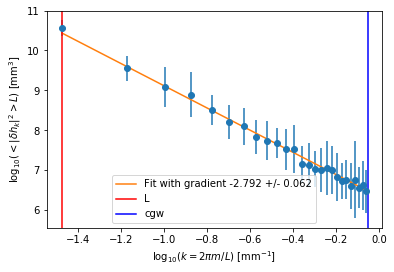

In [606]:
%matplotlib inline
plot_fft(dists, dL, PIX_2_mm)

In [691]:
mean_cross

array([[ 364.18266904, 1317.54097612],
       [ 364.08850416, 1313.81656372],
       [ 365.10377091, 1312.13454696],
       ...,
       [1788.45957059,  580.24412084],
       [1790.42380172,  580.30908934],
       [1793.16723649,  581.80852403]])

In [612]:
from scipy import signal

In [633]:
y = signal.savgol_filter(mean_cross[:, 1], 901, 3)

In [635]:
plt.imshow(ims[0], cmap='gray')
plt.plot(*mean_cross.T)
plt.plot(mean_cross[:, 0], y)

In [700]:
from labvision import video

In [701]:
vid0filename = "/media/data/Data/FirstOrder/Interfaces/RecordFluctuatingInterfaceJanuary2020/Quick/16750001.MP4"
vid0 = video.ReadVideo(vid0filename)

In [703]:
ims = [vid0.read_next_frame() for f in range(vid0.num_frames)]

In [704]:
ims = [images.bgr_to_gray(im) for im in ims]
circles = [images.find_circles(im, 27, 200, 7, 16, 16)
           for im in tqdm(ims, 'Finding Circles')]






Finding Circles:   0%|          | 0/216 [00:00<?, ?it/s]



Finding Circles:   0%|          | 1/216 [00:00<00:33,  6.41it/s]



Finding Circles:   1%|          | 2/216 [00:00<00:32,  6.62it/s]



Finding Circles:   1%|▏         | 3/216 [00:00<00:30,  7.07it/s]



Finding Circles:   2%|▏         | 4/216 [00:00<00:28,  7.34it/s]



Finding Circles:   2%|▏         | 5/216 [00:00<00:27,  7.68it/s]



Finding Circles:   3%|▎         | 6/216 [00:00<00:26,  7.83it/s]



Finding Circles:   3%|▎         | 7/216 [00:00<00:26,  7.93it/s]



Finding Circles:   4%|▎         | 8/216 [00:01<00:26,  7.76it/s]



Finding Circles:   4%|▍         | 9/216 [00:01<00:26,  7.90it/s]



Finding Circles:   5%|▍         | 10/216 [00:01<00:25,  8.05it/s]



Finding Circles:   5%|▌         | 11/216 [00:01<00:25,  8.03it/s]



Finding Circles:   6%|▌         | 12/216 [00:01<00:25,  8.06it/s]



Finding Circles:   6%|▌         | 13/216 [00:01<00:24,  8.14it/s]



Finding Circles:   6%|▋         | 14/216 [00:01<

Finding Circles:  47%|████▋     | 101/216 [00:12<00:13,  8.35it/s]



Finding Circles:  47%|████▋     | 102/216 [00:12<00:13,  8.20it/s]



Finding Circles:  48%|████▊     | 103/216 [00:12<00:13,  8.33it/s]



Finding Circles:  48%|████▊     | 104/216 [00:12<00:13,  8.40it/s]



Finding Circles:  49%|████▊     | 105/216 [00:12<00:13,  8.46it/s]



Finding Circles:  49%|████▉     | 106/216 [00:12<00:13,  8.44it/s]



Finding Circles:  50%|████▉     | 107/216 [00:13<00:12,  8.47it/s]



Finding Circles:  50%|█████     | 108/216 [00:13<00:12,  8.69it/s]



Finding Circles:  50%|█████     | 109/216 [00:13<00:12,  8.65it/s]



Finding Circles:  51%|█████     | 110/216 [00:13<00:12,  8.55it/s]



Finding Circles:  51%|█████▏    | 111/216 [00:13<00:12,  8.29it/s]



Finding Circles:  52%|█████▏    | 112/216 [00:13<00:12,  8.46it/s]



Finding Circles:  52%|█████▏    | 113/216 [00:13<00:12,  8.48it/s]



Finding Circles:  53%|█████▎    | 114/216 [00:13<00:11,  8.57it/s]



Finding Circles:  53

Finding Circles:  93%|█████████▎| 200/216 [00:24<00:02,  7.88it/s]



Finding Circles:  93%|█████████▎| 201/216 [00:24<00:01,  8.01it/s]



Finding Circles:  94%|█████████▎| 202/216 [00:24<00:01,  8.03it/s]



Finding Circles:  94%|█████████▍| 203/216 [00:24<00:01,  8.08it/s]



Finding Circles:  94%|█████████▍| 204/216 [00:24<00:01,  8.01it/s]



Finding Circles:  95%|█████████▍| 205/216 [00:24<00:01,  8.07it/s]



Finding Circles:  95%|█████████▌| 206/216 [00:25<00:01,  7.64it/s]



Finding Circles:  96%|█████████▌| 207/216 [00:25<00:01,  7.73it/s]



Finding Circles:  96%|█████████▋| 208/216 [00:25<00:01,  7.91it/s]



Finding Circles:  97%|█████████▋| 209/216 [00:25<00:00,  8.02it/s]



Finding Circles:  97%|█████████▋| 210/216 [00:25<00:00,  8.00it/s]



Finding Circles:  98%|█████████▊| 211/216 [00:25<00:00,  8.03it/s]



Finding Circles:  98%|█████████▊| 212/216 [00:25<00:00,  7.93it/s]



Finding Circles:  99%|█████████▊| 213/216 [00:25<00:00,  8.05it/s]



Finding Circles:  99

In [708]:
data = dataframes.DataStore(savename, load=False)
for f, info in tqdm(enumerate(circles), 'Adding Circles'):
    data.add_tracking_data(f, info, ['x', 'y', 'r'])

calc = statistics.PropertyCalculator(data)
calc.order()

lattice_spacing = 10
x = np.arange(0, ims[0].shape[1], lattice_spacing)
y = np.arange(0, ims[0].shape[0], lattice_spacing)
x, y = np.meshgrid(x, y)

cgw = get_cgw(data.df.loc[0], 1.85)

fields = [coarse_order_field(data.df.loc[f], cgw, x, y) 
         for f in tqdm(range(len(ims)), 'Calculating Fields')]

field_threshold = get_field_threshold(fields, lattice_spacing, ims[0])

contours = [find_contours(f, field_threshold)
           for f in tqdm(fields, 'Calculating contours')]

# Multiply the contours by the lattice spacing and squeeze
contours = [c.squeeze()*lattice_spacing for c in contours]

# Close contours
contours = [close_contour(c) for c in contours]

# Convert to LineString
contours = [LineString(c) for c in contours]






Adding Circles: 0it [00:00, ?it/s]




Adding Circles: 66it [00:00, 652.35it/s]




Adding Circles: 122it [00:00, 621.22it/s]




Adding Circles: 171it [00:00, 574.24it/s]




Adding Circles: 216it [00:00, 500.47it/s]


[########################################] | 100% Completed |  0.8s







Calculating Fields:   0%|          | 0/216 [00:00<?, ?it/s]




Calculating Fields:   0%|          | 1/216 [00:00<00:27,  7.88it/s]




Calculating Fields:   1%|▏         | 3/216 [00:00<00:24,  8.61it/s]




Calculating Fields:   2%|▏         | 4/216 [00:00<00:23,  8.94it/s]




Calculating Fields:   3%|▎         | 6/216 [00:00<00:22,  9.40it/s]




Calculating Fields:   4%|▎         | 8/216 [00:00<00:21,  9.87it/s]




Calculating Fields:   4%|▍         | 9/216 [00:00<00:20,  9.88it/s]




Calculating Fields:   5%|▌         | 11/216 [00:01<00:20, 10.23it/s]




Calculating Fields:   6%|▌         | 13/216 [00:01<00:19, 10.52it/s]




Calculating Fields:   7%|▋         | 15/216 [00:01<00:18, 10.60it/s]




Calculating Fields:   8%|▊         | 17/216 [00:01<00:18, 10.56it/s]




Calculating Fields:   9%|▉         | 19/216 [00:01<00:18, 10.69it/s]




Calculating Fields:  10%|▉         | 21/216 [00:01<00:18, 10.39it/s]




Calculating Fields:  11%|█         | 23/216 [00:02<00:18, 10.

Calculating Fields:  84%|████████▍ | 181/216 [00:16<00:03, 11.06it/s]




Calculating Fields:  85%|████████▍ | 183/216 [00:16<00:03, 11.00it/s]




Calculating Fields:  86%|████████▌ | 185/216 [00:16<00:02, 11.16it/s]




Calculating Fields:  87%|████████▋ | 187/216 [00:17<00:02, 10.89it/s]




Calculating Fields:  88%|████████▊ | 189/216 [00:17<00:02, 10.78it/s]




Calculating Fields:  88%|████████▊ | 191/216 [00:17<00:02, 10.74it/s]




Calculating Fields:  89%|████████▉ | 193/216 [00:17<00:02, 10.76it/s]




Calculating Fields:  90%|█████████ | 195/216 [00:17<00:01, 10.70it/s]




Calculating Fields:  91%|█████████ | 197/216 [00:18<00:01, 10.89it/s]




Calculating Fields:  92%|█████████▏| 199/216 [00:18<00:01, 10.82it/s]




Calculating Fields:  93%|█████████▎| 201/216 [00:18<00:01, 10.92it/s]




Calculating Fields:  94%|█████████▍| 203/216 [00:18<00:01, 10.97it/s]




Calculating Fields:  95%|█████████▍| 205/216 [00:18<00:00, 11.17it/s]




Calculating Fields:  96%|█████████▌| 2

In [709]:
dists, crosses = zip(*[get_dists(xq, yq, c, centre_line) for c in tqdm(contours)])






  0%|          | 0/216 [00:00<?, ?it/s]




  0%|          | 1/216 [00:00<01:30,  2.39it/s]




  1%|          | 2/216 [00:00<01:29,  2.39it/s]




  1%|▏         | 3/216 [00:01<01:32,  2.31it/s]




  2%|▏         | 4/216 [00:01<01:29,  2.36it/s]




  2%|▏         | 5/216 [00:02<01:27,  2.42it/s]




  3%|▎         | 6/216 [00:02<01:29,  2.35it/s]




  3%|▎         | 7/216 [00:02<01:25,  2.45it/s]




  4%|▎         | 8/216 [00:03<01:24,  2.46it/s]




  4%|▍         | 9/216 [00:03<01:22,  2.51it/s]




  5%|▍         | 10/216 [00:04<01:20,  2.55it/s]




  5%|▌         | 11/216 [00:04<01:22,  2.48it/s]




  6%|▌         | 12/216 [00:04<01:24,  2.42it/s]




  6%|▌         | 13/216 [00:05<01:20,  2.51it/s]




  6%|▋         | 14/216 [00:05<01:21,  2.48it/s]




  7%|▋         | 15/216 [00:06<01:21,  2.47it/s]




  7%|▋         | 16/216 [00:06<01:29,  2.24it/s]




  8%|▊         | 17/216 [00:07<01:26,  2.29it/s]




  8%|▊         | 18/216 [00:07<01:25,  2.31it/s]




  9%|▉

 56%|█████▌    | 120/216 [00:51<00:44,  2.17it/s]




 56%|█████▌    | 121/216 [00:51<00:45,  2.08it/s]




 56%|█████▋    | 122/216 [00:51<00:43,  2.17it/s]




 57%|█████▋    | 123/216 [00:52<00:42,  2.21it/s]




 57%|█████▋    | 124/216 [00:52<00:42,  2.18it/s]




 58%|█████▊    | 125/216 [00:53<00:43,  2.11it/s]




 58%|█████▊    | 126/216 [00:53<00:41,  2.16it/s]




 59%|█████▉    | 127/216 [00:54<00:41,  2.17it/s]




 59%|█████▉    | 128/216 [00:54<00:40,  2.19it/s]




 60%|█████▉    | 129/216 [00:55<00:39,  2.22it/s]




 60%|██████    | 130/216 [00:55<00:38,  2.21it/s]




 61%|██████    | 131/216 [00:56<00:37,  2.27it/s]




 61%|██████    | 132/216 [00:56<00:37,  2.25it/s]




 62%|██████▏   | 133/216 [00:56<00:36,  2.28it/s]




 62%|██████▏   | 134/216 [00:57<00:36,  2.22it/s]




 62%|██████▎   | 135/216 [00:57<00:34,  2.34it/s]




 63%|██████▎   | 136/216 [00:58<00:33,  2.36it/s]




 63%|██████▎   | 137/216 [00:58<00:32,  2.40it/s]




 64%|██████▍   | 138/216 [00

In [710]:
plot_fft(dists, dL, PIX_2_mm)